In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings(action='ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as formula
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels as sm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
import joblib as jb
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

In [107]:
# get the name of the csv file  
file = r'C:\Users\Shanks\Downloads\B.Tech CSE\PM 2.5 Pollution Prediction Project\Dataset.csv'

# read the csv file into a pandas DataFrame using the pd.read_csv()
data = pd.read_csv(file)
data.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


<h3><b>Data Preprocessing</b></h3>

In [108]:
# drop the unwanted columns/features
cols_to_drop = ['No','station']
data = data.drop(cols_to_drop,axis=1)
# print out the info of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    35064 non-null  int64  
 1   month   35064 non-null  int64  
 2   day     35064 non-null  int64  
 3   hour    35064 non-null  int64  
 4   PM2.5   34139 non-null  float64
 5   PM10    34346 non-null  float64
 6   SO2     34129 non-null  float64
 7   NO2     34041 non-null  float64
 8   CO      33288 non-null  float64
 9   O3      33345 non-null  float64
 10  TEMP    35044 non-null  float64
 11  PRES    35044 non-null  float64
 12  DEWP    35044 non-null  float64
 13  RAIN    35044 non-null  float64
 14  wd      34983 non-null  object 
 15  WSPM    35050 non-null  float64
dtypes: float64(11), int64(4), object(1)
memory usage: 4.3+ MB


In [109]:
# check for duplicated values and null values
print('Are there any duplicated values in our data ? : {}\n'.format(data.duplicated().any()))
print('The total number of null values in each colum:')
display(data.isnull().sum())

Are there any duplicated values in our data ? : False

The total number of null values in each colum:


year        0
month       0
day         0
hour        0
PM2.5     925
PM10      718
SO2       935
NO2      1023
CO       1776
O3       1719
TEMP       20
PRES       20
DEWP       20
RAIN       20
wd         81
WSPM       14
dtype: int64

In [110]:
# find the most appearing wind direction value
data.wd.mode()

0    NE
Name: wd, dtype: object

In [111]:
# fill in the missing values with the mean of the particular column
data.fillna(value=data.mean(),inplace=True)
# replace the missing values for the wind direction with the modal value
data.wd.fillna(value='NE',inplace=True)
# let's check the data again if there are any missing values
data.isnull().any()

year     False
month    False
day      False
hour     False
PM2.5    False
PM10     False
SO2      False
NO2      False
CO       False
O3       False
TEMP     False
PRES     False
DEWP     False
RAIN     False
wd       False
WSPM     False
dtype: bool

In [112]:
# create a datetime column using the year,month,day and hour columns.
years = data['year'].values
months = data['month'].values
days = data['day'].values
hours = data['hour'].values
full_date = []

for i in range(data.shape[0]):
    date_time = str(years[i])+'-'+str(months[i])+'-'+str(days[i])+' '+str(hours[i])+':'+str(0)
    full_date.append(date_time)

dates = pd.to_datetime(full_date)
dates = pd.DataFrame(dates,columns=['date'])
data = pd.concat([dates,data],axis=1)

data.head()

,date,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,2013-03-01 00:00:00,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4
1,2013-03-01 01:00:00,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7
2,2013-03-01 02:00:00,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6
3,2013-03-01 03:00:00,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1
4,2013-03-01 04:00:00,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0


<h3><b>Data Analysis</b></h3>

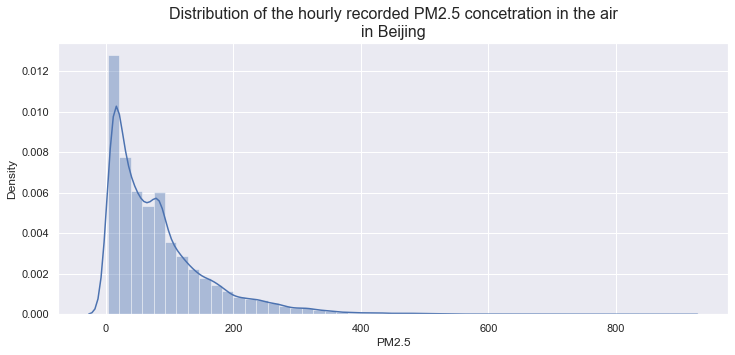

In [113]:
plt.figure(figsize=(12,5))
sns.distplot(data['PM2.5'],bins=50)
plt.title('Distribution of the hourly recorded PM2.5 concetration in the air\nin Beijing',
          fontsize=16)
plt.show()

<h5><b>what pattern does the amount of PM2.5 concentration in the air recorded in an hour follow
        for a daily time period ?</b></h5>

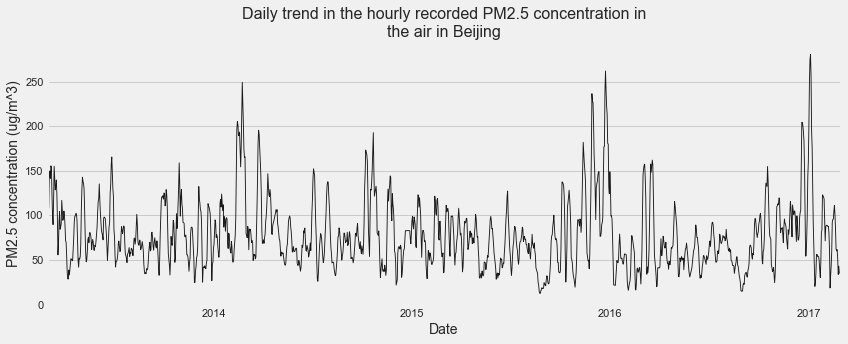

In [114]:
# find the daily average of PM2.5 contained in the air in any given hour
daily_data = data[['date','PM2.5']]
daily_data = daily_data.set_index('date')
daily_data = daily_data.resample('D').median()
decomposition = seasonal_decompose(daily_data,model='addictive')

# plot the data
with plt.style.context('fivethirtyeight'):
    decomposition.trend.plot(figsize=(12,5),style='k',linewidth=.9)
    plt.xlabel('Date',fontsize=14)
    plt.ylabel('PM2.5 concentration (ug/m^3)',fontsize=14)
    plt.title('Daily trend in the hourly recorded PM2.5 concentration in\nthe air in Beijing',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

<h5><b>In which month does the amount of PM2.5 contained in the air rises ?</b></h5>

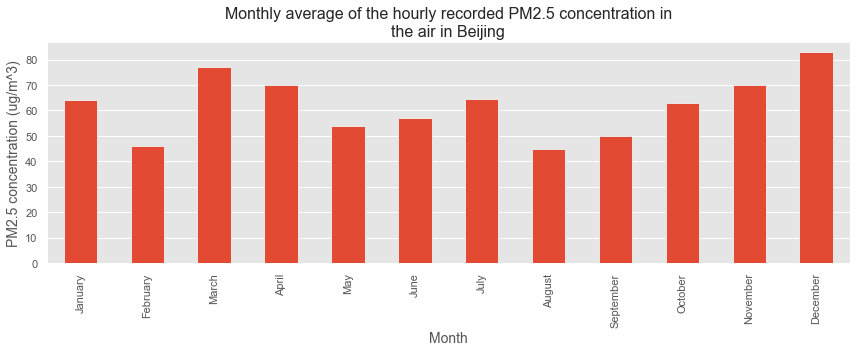

In [115]:
monthly_data = data[['month','PM2.5']]
months = ['January','February','March','April','May','June','July',
         'August','September','October','November','December']
ordered_monthdf = pd.DataFrame(months,columns=['month'])
map_dict = {}
for i,j in enumerate(months):
    map_dict.setdefault(i+1,j)

monthly_data.month = monthly_data.month.map(map_dict)
monthly_average = monthly_data.groupby('month').median()
monthly_average = pd.merge(ordered_monthdf,monthly_average,left_on='month',right_index=True)
monthly_average = np.round(monthly_average,1)
monthly_average = monthly_average.set_index('month')

# plot the data
with plt.style.context('ggplot'):
    monthly_average.plot(figsize=(12,5),legend=False,kind='bar',linewidth=.9)
    plt.xlabel('Month',fontsize=14)
    plt.ylabel('PM2.5 concentration (ug/m^3)',fontsize=14)
    plt.title('Monthly average of the hourly recorded PM2.5 concentration in\nthe air in Beijing',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

<h5><b>At what time of the day do we expect the amount of PM2.5 concentration in the air to be high ?</b></h5>

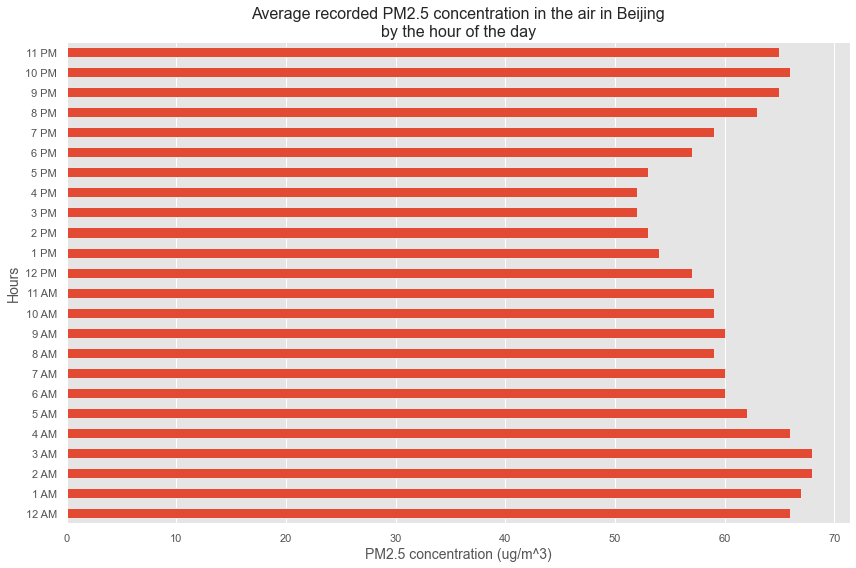

In [116]:
hourly_data = data[['hour','PM2.5']]
hrs = ['12 AM','1 AM','2 AM','3 AM','4 AM','5 AM','6 AM','7 AM','8 AM','9 AM','10 AM',
      '11 AM','12 PM','1 PM','2 PM','3 PM','4 PM','5 PM','6 PM','7 PM',
      '8 PM','9 PM','10 PM','11 PM']
hour_dict = {}
for i,j in enumerate(hrs):
    hour_dict.setdefault(i,j)
    
hourly_data = hourly_data.groupby('hour').median().reset_index()
hourly_data.hour = hourly_data.hour.map(hour_dict)
hourly_data = hourly_data.set_index('hour')

# plot the data
with plt.style.context('ggplot'):
    hourly_data.plot(figsize=(12,8),legend=False,kind='barh',linewidth=.9)
    plt.ylabel('Hours',fontsize=14)
    plt.xlabel('PM2.5 concentration (ug/m^3)',fontsize=14)
    plt.title('Average recorded PM2.5 concentration in the air in Beijing\nby the hour of the day',fontsize=16)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

<h5><b>In which direction does polluted air/wind mostly move ?</b></h5>

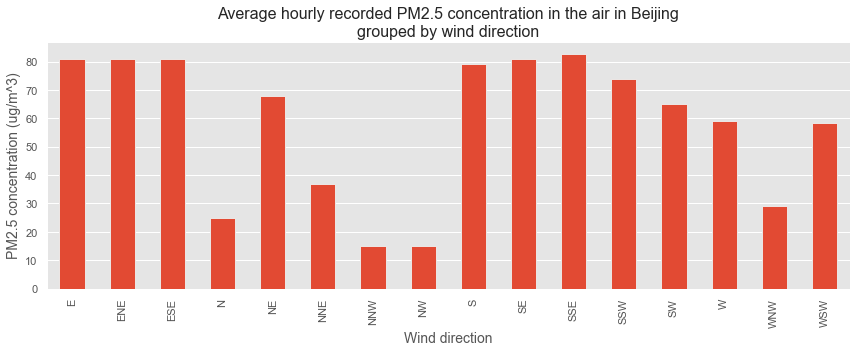

In [117]:
wind_dir = data[['wd','PM2.5']]
wind_dir = wind_dir.groupby('wd').median()

# plot the data
with plt.style.context('ggplot'):
    wind_dir.plot(figsize=(12,5),legend=False,kind='bar',linewidth=.9)
    plt.xlabel('Wind direction',fontsize=14)
    plt.ylabel('PM2.5 concentration (ug/m^3)',fontsize=14)
    plt.title('Average hourly recorded PM2.5 concentration in the air in Beijing\ngrouped by wind direction',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

<h5><b>How do the other environmental factors affect the amount of PM2.5 concentration in the air ?</b></h5>

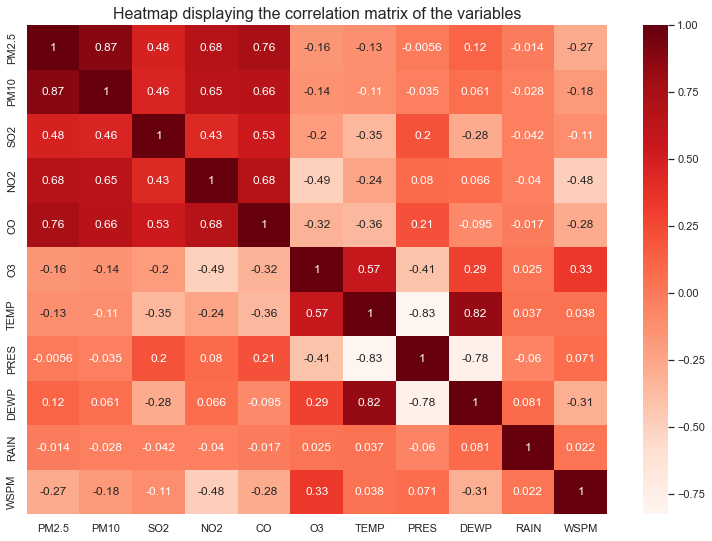

In [118]:
# visualize the relationships between the features of the data
plt.figure(figsize=(13,9))
correlation_data = data[['PM2.5', 'PM10', 'SO2', 'NO2',
                         'CO', 'O3', 'TEMP', 'PRES',
                         'DEWP', 'RAIN', 'WSPM']]
sns.heatmap(correlation_data.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the correlation matrix of the variables',fontsize=16)
plt.show()

<h3><b>Model Training and Evaluation</b></h3>

In [119]:
cols_to_drop = ['date','year','month','day','hour','wd']
newdata = data.drop(cols_to_drop,axis=1)

# calculate the variance inflation factor of each feature and detect multicollinearity
cons_data = sm.tools.add_constant(newdata)
series_before = pd.Series([variance_inflation_factor(cons_data.values,i) for i in range(cons_data.shape[1])],
                         index=cons_data.columns)
series_before

const    35340.419725
PM2.5        6.350322
PM10         4.811566
SO2          1.670510
NO2          3.320432
CO           3.159039
O3           2.250103
TEMP         8.214959
PRES         3.667310
DEWP         6.517281
RAIN         1.023639
WSPM         1.788731
dtype: float64

In [120]:
# we can see that TEMP (temperature) and DEWP (dewpoint) are highly correlated as the VIF value is 
# greater than 5. As a result, we get rid of one of those features and probably the one that has the 
# lowest correlation with the dependent variable.
newdata = newdata.drop('DEWP',axis=1)
cons_data2 = sm.tools.add_constant(newdata)
series_after = pd.Series([variance_inflation_factor(cons_data2.values,i) for i in range(cons_data2.shape[1])],
                         index=cons_data2.columns)
series_after

const    33490.920665
PM2.5        5.972024
PM10         4.704558
SO2          1.560019
NO2          3.314615
CO           3.133916
O3           2.168322
TEMP         4.559340
PRES         3.463731
RAIN         1.009170
WSPM         1.460474
dtype: float64

In [121]:
newdata.columns = ['PM2_5','PM10','SO2','NO2','CO','O3','TEMP','PRES','RAIN','WSPM']

# PM2.5 is skewed to the right so we log transform the values to normalize the distribution
newdata['PM2_5'] = np.log(newdata['PM2_5'])

In [122]:
# fit the regression model
mul_reg = formula.ols(formula='PM2_5 ~ PM10 + SO2 + NO2 + CO + O3 + TEMP + PRES + RAIN + WSPM',
                      data=newdata).fit()
mul_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PM2_5   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     9636.
Date:                Sat, 02 Jul 2022   Prob (F-statistic):               0.00
Time:                        04:39:27   Log-Likelihood:                -30906.
No. Observations:               35064   AIC:                         6.183e+04
Df Residuals:                   35054   BIC:                         6.192e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.5181      0.571      9.668      0.000       4.399       6.637
PM10           0.0056   5.11e-05    109.188      0.000       0.005       0.006
SO2            0.0040      0.000     23.039      0.000       0.004       0.004
NO2            0.0060      0.000     39.113      0.000       0.006       0.006
CO             0.0002    4.2e-06     40.083      0.000       0.000       0.000
O3             0.0021    8.1e-05     25.491      0.000       0.002       0.002
TEMP           0.0110      0.001     18.899      0.000       0.010       0.012
PRES          -0.0028      0.001     -5.102      0.000      -0.004      -0.002
RAIN           0.0237      0.003      6.888      0.000       0.017       0.030
WSPM          -0.1399      0.003    -45.047      0.000      -0.146      -0.134
==============================================================================
Omnibus:                     3697.836   Durbin-Watson:                   0.373
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5978.516
Skew:                          -0.761   Prob(JB):                         0.00
Kurtosis:                       4.333   Cond. No.                     3.50e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.5e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<p>The OLS model from statsmodels gives us an accuracy of 71% (0.712) which is not satisfactory for prediction. So we move on to fit a linear regression model from the scikit-learn library.</p>
<br>

## Ensemble Method

In [123]:
ensemble_data = data.drop(cols_to_drop,axis=1)

# we split the data into predictor variables and Outcome variable
X = ensemble_data.drop('PM2.5',axis=1)
y = ensemble_data['PM2.5']

In [124]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=.2)

### RandomForestRegressor

we now fit a random forest regression model on the data to see if we would get a better accuracy results than that of the decision tree regression model.

In [125]:
# instantiate the RandomForestRegressor model and fit the model on the training data
forest = RandomForestRegressor(n_estimators=100,
                              max_depth=7,
                              max_features='auto',
                              min_samples_split=7,
                              min_samples_leaf=3)

forest.fit(xtrain,ytrain)

RandomForestRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=7)

In [126]:
# we now score the model
print('Score on train data: {}\n'.format(forest.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(forest.score(xtest,ytest)))

forest_pred = forest.predict(xtest)
forest_mse = mean_squared_error(ytest,forest_pred)
forest_accuracy = r2_score(ytest,forest_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(forest_mse)))
print('Overall model accuracy: {}'.format(forest_accuracy))

Score on train data: 0.9147933554810875

Score on test data: 0.9063349033281217

Root Mean Squared Error: 24.40726651146779

Overall model accuracy: 0.9063349033281217


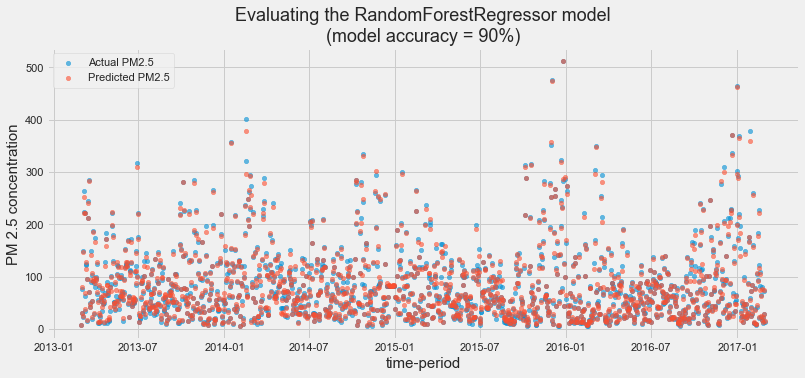

In [127]:
# we now use the Random Forest Regressor model to predict the PM2.5 concetration and 
# compare it to the actual PM2.5 recorded in the data by means of visualization

compare_data = pd.DataFrame({'dates':data['date'],
                            'Actual PM2.5':y,
                            'Predicted PM2.5':gboost_search.predict(X.values)})

compare_data.set_index('dates',inplace=True)
compare_data['Predicted PM2.5'] = np.round(compare_data['Predicted PM2.5'],1)

# let's plot the daily averages of the Actual PM10 and the predicted PM2.5 concentration.
compare_data = compare_data.resample('D').mean()

with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(12,5))
    plt.scatter(compare_data.index,compare_data['Actual PM2.5'],s=20,label='Actual PM2.5',
               alpha=.6)
    plt.scatter(compare_data.index,compare_data['Predicted PM2.5'],s=20,label='Predicted PM2.5',
               alpha=.6)
    plt.legend()
    plt.title('Evaluating the RandomForestRegressor model\n(model accuracy = 90%)',
             fontsize=18)
    plt.xlabel('time-period',fontsize=15)
    plt.ylabel('PM 2.5 concentration',fontsize=15)
    plt.show()

<h3><b>Saving and loading the model</b></h3>

In [128]:
import joblib as jb

In [129]:
# save the model
jb.dump(gboost_search,'C:\\Users\\Shanks\\Downloads\\B.Tech CSE\\PM 2.5 Pollution Prediction Project\\models\\pm25_model.pkl')

['C:\\Users\\Shanks\\Downloads\\B.Tech CSE\\PM 2.5 Pollution Prediction Project\\models\\pm25_model.pkl']

In [130]:
# loading the model
regression_model = jb.load('C:\\Users\\Shanks\\Downloads\\B.Tech CSE\\PM 2.5 Pollution Prediction Project\\models\\pm25_model.pkl')